## Importing required tools

In [1]:
import sqlite3 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
conn = sqlite3.connect('../../data/zippedData/im.db')

## Importing Budget Data

In [2]:
movie_budget = pd.read_csv('../../data/zippedData/tn.movie_budgets.csv.gz')
movie_budget.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


## Pulling Necessary Data from SQL Database
-Need to decide the data that we want to pull from here 
-Should take advantage of joins and more 

In [3]:
imbd = pd.read_sql("""
SELECT DISTINCT mb.primary_title, mb.genres,  p.primary_name as director
FROM movie_basics as mb,
directors as d on d.movie_id = mb.movie_id,
persons as p on d.person_id = p.person_id
; """, conn)
imbd

,primary_title,genres,director
0,Sunghursh,"Action,Crime,Drama",Harnam Singh Rawail
1,One Day Before the Rainy Season,"Biography,Drama",Mani Kaul
2,The Other Side of the Wind,Drama,Orson Welles
3,Sabse Bada Sukh,"Comedy,Drama",Hrishikesh Mukherjee
4,The Wandering Soap Opera,"Comedy,Drama,Fantasy",Raoul Ruiz
...,...,...,...
163103,Rodolpho Teóphilo - O Legado de um Pioneiro,Documentary,Ana Célia de Oliveira
163104,Dankyavar Danka,Comedy,Kanchan Nayak
163105,6 Gunn,None,Kiran Gawade
163106,Chico Albuquerque - Revelações,Documentary,Vinicius Augusto Bozzo


## Testing out Joins 
-This cell joins the movie_budget table with the SQL data pulled from above

In [4]:
joins = movie_budget.set_index('movie').join(imbd.set_index('primary_title'), how='inner')
joins.reset_index(inplace=True)
joins.groupby('id').first()
joins

,index,id,release_date,production_budget,domestic_gross,worldwide_gross,genres,director
0,#Horror,16,"Nov 20, 2015","$1,500,000",$0,$0,"Crime,Drama,Horror",Tara Subkoff
1,10 Cloverfield Lane,54,"Mar 11, 2016","$5,000,000","$72,082,999","$108,286,422","Drama,Horror,Mystery",Dan Trachtenberg
2,10 Days in a Madhouse,48,"Nov 11, 2015","$12,000,000","$14,616","$14,616",Drama,Timothy Hines
3,12 Rounds,37,"Mar 27, 2009","$20,000,000","$12,234,694","$17,306,648","Action,Drama,Romance",Gabriel Soriano
4,12 Strong,64,"Jan 19, 2018","$35,000,000","$45,819,713","$71,118,378","Action,Drama,History",Nicolai Fuglsig
...,...,...,...,...,...,...,...,...
4162,Zootopia,57,"Mar 4, 2016","$150,000,000","$341,268,248","$1,019,429,616","Adventure,Animation,Comedy",Byron Howard
4163,Zootopia,57,"Mar 4, 2016","$150,000,000","$341,268,248","$1,019,429,616","Adventure,Animation,Comedy",Rich Moore
4164,Zootopia,57,"Mar 4, 2016","$150,000,000","$341,268,248","$1,019,429,616","Adventure,Animation,Comedy",Jared Bush
4165,Zulu,82,"Dec 31, 2013","$16,000,000",$0,"$1,844,228","Crime,Drama,Thriller",Jérôme Salle


## Getting rid of Duplicate data
-Because some movies in our data set had multiple directors attributed to the movie we were getting duplicated movies. Because of this we decided to choose the first director listed within director column

In [5]:
joins = joins.groupby('index').nth(0)

## Chooses only the first genre

In [6]:

joins['genres'] = joins['genres'].str.split(",")
joins['genres'] = joins['genres'].fillna('Unknown')
for x in range(joins['genres'].count()):
    if joins['genres'][x] == 'Unknown':
        joins['genres'][x] = 'Unknown'
    else:
        joins['genres'][x] = joins['genres'][x][0]
        x +=1
joins

<ipython-input-6-608fd6d50ce4>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joins['genres'][x] = joins['genres'][x][0]
<ipython-input-6-608fd6d50ce4>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joins['genres'][x] = 'Unknown'


,id,release_date,production_budget,domestic_gross,worldwide_gross,genres,director
index,,,,,,,
#Horror,16,"Nov 20, 2015","$1,500,000",$0,$0,Crime,Tara Subkoff
10 Cloverfield Lane,54,"Mar 11, 2016","$5,000,000","$72,082,999","$108,286,422",Drama,Dan Trachtenberg
10 Days in a Madhouse,48,"Nov 11, 2015","$12,000,000","$14,616","$14,616",Drama,Timothy Hines
12 Rounds,37,"Mar 27, 2009","$20,000,000","$12,234,694","$17,306,648",Action,Gabriel Soriano
12 Strong,64,"Jan 19, 2018","$35,000,000","$45,819,713","$71,118,378",Action,Nicolai Fuglsig
...,...,...,...,...,...,...,...
Zoolander 2,64,"Feb 12, 2016","$50,000,000","$28,848,693","$55,348,693",Comedy,Ben Stiller
Zoom,26,"Aug 11, 2006","$35,000,000","$11,989,328","$12,506,188",Animation,Pedro Morelli
Zootopia,57,"Mar 4, 2016","$150,000,000","$341,268,248","$1,019,429,616",Adventure,Byron Howard


## Cleaning the data
-Turning the money string values into integers 

In [7]:
joins['domestic_gross']= joins['domestic_gross'].str.replace(',','')
joins['domestic_gross']= joins['domestic_gross'].str.replace('$','')
joins['domestic_gross'] = pd.to_numeric(joins['domestic_gross'])
joins['worldwide_gross']= joins['worldwide_gross'].str.replace(',','')
joins['worldwide_gross']= joins['worldwide_gross'].str.replace('$','')
joins['worldwide_gross'] = pd.to_numeric(joins['worldwide_gross'])
joins['production_budget']= joins['production_budget'].str.replace(',','')
joins['production_budget']= joins['production_budget'].str.replace('$','')
joins['production_budget'] = pd.to_numeric(joins['production_budget'])

## Creating a Profit column 

In [8]:
joins['profit'] = joins['worldwide_gross'] - joins['production_budget']
joins = joins.sort_values('profit', ascending=False)
joins.at['Avatar','director'] = 'James Cameron'
joins.at['Titanic','director'] = 'James Cameron'

joins

,id,release_date,production_budget,domestic_gross,worldwide_gross,genres,director,profit
index,,,,,,,,
Avatar,1,"Dec 18, 2009",425000000,760507625,2776345279,Horror,James Cameron,2351345279
Titanic,43,"Dec 19, 1997",200000000,659363944,2208208395,Adventure,James Cameron,2008208395
Avengers: Infinity War,7,"Apr 27, 2018",300000000,678815482,2048134200,Action,Anthony Russo,1748134200
Jurassic World,34,"Jun 12, 2015",215000000,652270625,1648854864,Action,Colin Trevorrow,1433854864
Furious 7,67,"Apr 3, 2015",190000000,353007020,1518722794,Action,James Wan,1328722794
...,...,...,...,...,...,...,...,...
Call of the Wild,36,"Feb 21, 2020",82000000,0,0,Adventure,Chris Sanders,-82000000
Bright,80,"Dec 13, 2017",90000000,0,0,Action,David Ayer,-90000000
Men in Black: International,42,"Jun 14, 2019",110000000,3100000,3100000,Action,F. Gary Gray,-106900000


In [13]:
imbd.loc[joins['primary_title'] == 'Terminator', 'director']

KeyError: 'primary_title'

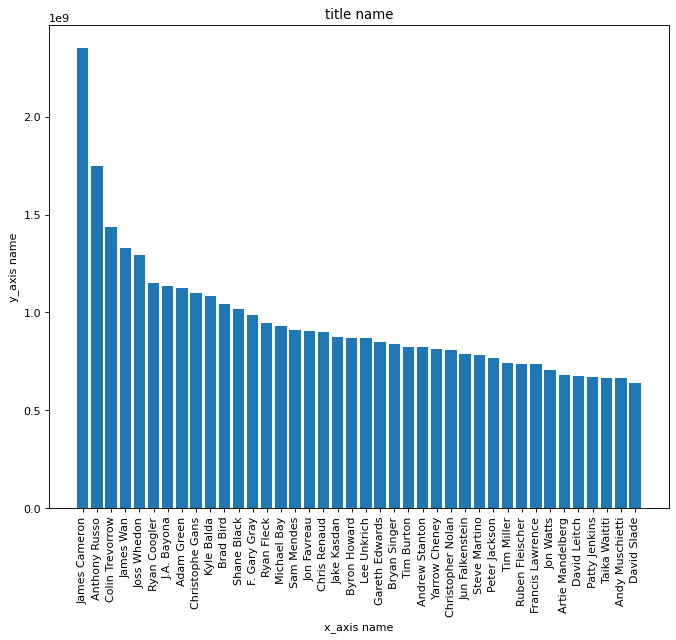

In [10]:
from matplotlib.pyplot import figure

x_axis = joins['director'].head(50)
y_axis = joins['profit'].head(50) 

figure(figsize=(10, 8), dpi=80)

plt.bar(x_axis, y_axis)
plt.xticks(rotation=90)
plt.title('title name')
plt.xlabel('x_axis name')
plt.ylabel('y_axis name')
plt.show()

In [95]:
copy = joins 
movies = []
n = len(copy)

for x in range(n):
    movies.append(copy.index[x])
movies

copy['movies'] = movies

copy

,id,release_date,production_budget,domestic_gross,worldwide_gross,genres,director,profit,movies
index,,,,,,,,,
Avatar,1,"Dec 18, 2009",425000000,760507625,2776345279,Horror,James Cameron,2351345279,Avatar
Titanic,43,"Dec 19, 1997",200000000,659363944,2208208395,Adventure,James Cameron,2008208395,Titanic
Avengers: Infinity War,7,"Apr 27, 2018",300000000,678815482,2048134200,Action,Anthony Russo,1748134200,Avengers: Infinity War
Jurassic World,34,"Jun 12, 2015",215000000,652270625,1648854864,Action,Colin Trevorrow,1433854864,Jurassic World
Furious 7,67,"Apr 3, 2015",190000000,353007020,1518722794,Action,James Wan,1328722794,Furious 7
...,...,...,...,...,...,...,...,...,...
Call of the Wild,36,"Feb 21, 2020",82000000,0,0,Adventure,Chris Sanders,-82000000,Call of the Wild
Bright,80,"Dec 13, 2017",90000000,0,0,Action,David Ayer,-90000000,Bright
Men in Black: International,42,"Jun 14, 2019",110000000,3100000,3100000,Action,F. Gary Gray,-106900000,Men in Black: International


In [123]:
percentage = int(round((len(copy['director'])/4),0))

top50_dir = copy['director'].value_counts().head(percentage)
top50_dir = top50_dir.index
top50_dir



Index(['Steven Spielberg', 'David Gordon Green', 'Ridley Scott',
       'Steven Soderbergh', 'Jon M. Chu', 'Denis Villeneuve', 'Clint Eastwood',
       'Antoine Fuqua', 'Paul W.S. Anderson', 'Francis Lawrence',
       ...
       'Ben Lewin', 'Richard Montoya', 'Rob Thomas', 'Todd Graff',
       'Hermine Huntgeburth', 'Steve Whelan', 'Taylor Hayden', 'Darrell Roodt',
       'Richard Glatzer', 'Chuck Russell'],
      dtype='object', length=574)

In [124]:
top50_dir_movies = copy.loc[copy['director'].isin(top50_dir), 'profit']
top50_dir_profit = top50_dir_movies.values


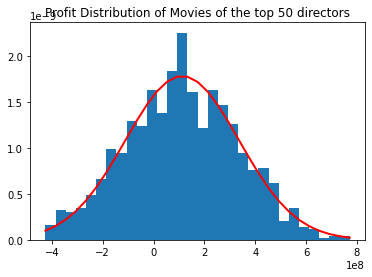

1090


In [126]:
top50_dir_profit_mean = top50_dir_profit.mean() 
top50_dir_profit_std = top50_dir_profit.std()
top50_dir_profit_n = len(top50_dir_profit)

s1  = np.random.normal(top50_dir_profit_mean,top50_dir_profit_std, top50_dir_profit_n)
count, bins, ignored = plt.hist(s1,30, density=True)
plt.plot(bins, 1/(top50_dir_profit_std * np.sqrt(2 * np.pi)) *
               np.exp( - (bins - top50_dir_profit_mean)**2 / (2 * top50_dir_profit_std**2) ),
         linewidth=2, color='r')

plt.title('Profit Distribution of Movies of the top 50 directors')

plt.show()
print(top50_dir_profit_n)